In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
import pandas as pd
import numpy as np

# allows importing notebooks as modules
from notebook_import import *

# calculation of statistical distribution parameters
from statsmodels.stats.proportion import proportion_confint

from log_parsing_notebook import load_behavioral_data, compile_trials
from utility_functions import prop_true, pandas_series_tuple_unpack

TDMS_PATH = 'D:/Work/tdms_logs'
TXT_PATH = 'D:/Dropbox/Work/envelope_discrimination/txt_logs'
CSV_PATH = 'D:/Dropbox/Work/envelope_discrimination/csv_logs'
RATS = ['S8','S9','S10']

importing Jupyter notebook from D:\Dropbox\Work\iPython\log_parsing_notebook.ipynb
importing Jupyter notebook from D:\Dropbox\Work\iPython\utility_functions.ipynb


In [2]:
# load behavioral data into memory
ld = load_behavioral_data(TXT_PATH,TDMS_PATH,CSV_PATH,RATS)

In [3]:
drop_sessions = ['20160712S8', # task parameter (delay) changed and the rat was confused
                 '20160713S8',
                 '20160714S8',
                 '20160715S8',
                 '20160716S8',
                 '20160717S8']



sessions_with_mixed_trials = pd.Series([s for s in ld.index if 'Mixed_trial_info' in ld[s].keys() 
                              # only select sessions with '5-1' sequences present (these will also contain '1-5') 
                              and '5-1' in ld[s].Mixed_trial_info.unique()
                              # drop some sessions for various reasons
                              and s not in drop_sessions])

# leave only relevant sessions with mixed trials
ld = ld[sessions_with_mixed_trials]
print('There are %s sessions with mixed trials.' % len(ld))

There are 114 sessions with mixed trials.


D:\Programs\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [4]:
# create a tidy dataset with all trials
trials = compile_trials(ld)

print('There are %s trials in total, %s of them are mixed trials' %
     (len(trials), len(trials.dropna(subset=['mixed_sequence']))) )

There are 27659 trials in total, 1594 of them are mixed trials


#### Visualize performance on normal trials for each rat and session
This allows to see trends in the long-term, and visually check if performance in some periods is strangely low. Chance performance is 50%.

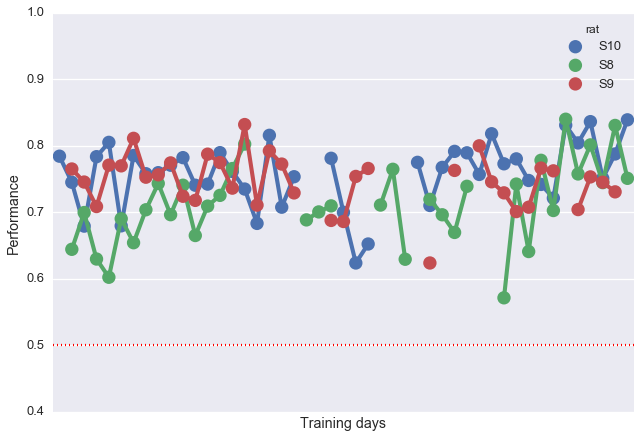

In [14]:
# get normal trials only
nt = trials[trials.mixed_sequence.isnull()]

# groupby rat and date and calculate proportion of correct trials,
# which gives performance on each session for each rat
perf = nt.groupby(['rat','date']).correct.apply(prop_true).reset_index()

# plot
sns.pointplot(data=perf,x='date',y='correct',hue='rat')
plt.xticks([])
plt.xlabel('Training days')
plt.ylim([0.4,1])
plt.ylabel('Performance')
# chance level performance
plt.axhline(0.5,linestyle=':',color='r')
plt.show()

#### Analyse mixed trials
On normal trials, in which modulation frequency does not change during the stimulus, but stays the same for 2 sec, rats were trained to make right choice on 5 Hz modulation, and left choice on 1 Hz modulation, and their performance was high on these trials (>70% on average). 

Mixed trials are trials with one modulation frequency in the first sec and another in the second sec: 1 Hz in the first sec and 5 Hz in the second sec (1-5 mixed sequence), or vice versa (5-1 mixed sequence). Mixed trials were rewarded on either side, and had no obvious side of choice, since both 1 Hz and 5 Hz modulation were present on each trial, only the order of modulation frequencies was different. The question is how rats decide to choose on these trials -- according to the first modulation frequency or the second one, or randomly. This will tell us which part of the stimulus has more weight for the animal.

In [6]:
# get only mixed trials
mt = trials[trials.mixed_sequence.notnull()]

# calculate proportion of choice to right for 5-1 and 5-1 mixed sequences for each rat 
calculate_prop_right = lambda x: (sum(x=='Right')/len(x), len(x))
prop_right = mt.groupby(['rat','mixed_sequence'])['choice'].apply(calculate_prop_right)

prop_right = pandas_series_tuple_unpack(prop_right, ['prop_choices_right','n'])

# calculate binomial confidence interval for performance
for row in prop_right.iterrows():
    (prop_right.loc[row[0],'ci_0'],prop_right.loc[row[0],'ci_1']) = \
    proportion_confint(row[1].n*row[1].prop_choices_right,row[1].n,0.05)

prop_right

prop_choices_right    n      ci_0      ci_1
rat mixed_sequence                                             
S10 1-5                       0.718412  277  0.665445  0.771378
    5-1                       0.259786  281  0.208514  0.311059
S8  1-5                       0.709924  262  0.654975  0.764873
    5-1                       0.426415  265  0.366871  0.485959
S9  1-5                       0.738462  260  0.685043  0.791880
    5-1                       0.373494  249  0.313411  0.433577

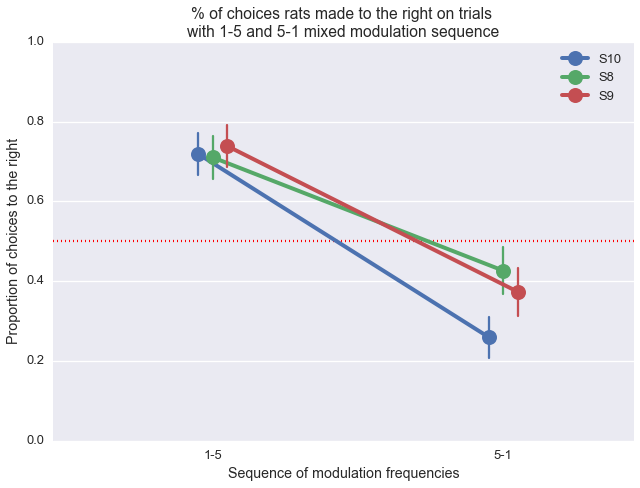

In [12]:
# plot choices % mixed trials

for (i,rat) in enumerate(prop_right.index.levels[0]):
    # plot % choices
    spacing = 0.05
    x_1 = 0+i*spacing
    x_2 = 1+i*spacing
    plt.plot([x_1,x_2],
             prop_right.loc[(rat,),'prop_choices_right'].values,
             '-o',c=sns.color_palette(n_colors=3)[i],markersize=15,linewidth=4,label=rat)
    
    # plot confidence intervals
    plt.plot([x_1]*2,prop_right.loc[(rat,'1-5'),['ci_0','ci_1']],
            c=sns.color_palette(n_colors=3)[i],label='')
    plt.plot([x_2]*2,prop_right.loc[(rat,'5-1'),['ci_0','ci_1']],
            c=sns.color_palette(n_colors=3)[i],label='')

plt.xlim(-0.5,1.5)
plt.grid('off',axis='x')
plt.xticks([0+spacing*i/2,1+spacing*i/2],['1-5','5-1'])
plt.xlabel('Sequence of modulation frequencies')

plt.ylim(0,1)
plt.ylabel('Proportion of choices to the right')

plt.title('% of choices rats made to the right on trials \nwith 1-5 and 5-1 mixed modulation sequence')

plt.legend()

# chance level choice
plt.axhline(0.5,linestyle=':',color='r',zorder=0.5)

plt.show()

All 3 experimental rats clearly tended to choose right on 1-5 trials and left on 5-1 trials, which means that they tended to choose according to the **second** modulation frequency presented on the mixed trials.

Next question we ask is how performance on the mixed trials (i.e. % of choices made in accordance with the second frequency in the mixed sequence) compares with the performance on normal trials. Is it statistically different from normal performance or not? This will tell us whether the rats take first frequency into account on mixed trials or just ignore it.

In [223]:
# covert % choices on mixed trials to performance as if second modulation
# frequency should've been chosen

prop_right.loc[idx[:,'5-1'],['prop_choices_right','ci_0','ci_1']] = \
    1 - prop_right.loc[idx[:,'5-1'],['prop_choices_right','ci_0','ci_1']]
    
prop_right

prop_choices_right    n      ci_0      ci_1
rat mixed_sequence                                             
S10 1-5                       0.718412  277  0.665445  0.771378
    5-1                       0.740214  281  0.791486  0.688941
S8  1-5                       0.709924  262  0.654975  0.764873
    5-1                       0.573585  265  0.633129  0.514041
S9  1-5                       0.738462  260  0.685043  0.791880
    5-1                       0.626506  249  0.686589  0.566423

In [95]:
# calculate performance (perf) on normal trials for each rat and number of trials (n)
nt = trials.loc[trials.mixed_sequence.isnull()]
nt_perf = nt.groupby(['rat','reward'])['correct'].apply(lambda x: prop_true(x,return_len=1))
nt_perf = pandas_series_tuple_unpack(nt_perf, ['perf','n'])

# calculate binomial confidence interval for performance
for row in nt_perf.iterrows():
    (nt_perf.loc[row[0],'ci_0'],nt_perf.loc[row[0],'ci_1']) = \
    proportion_confint(row[1].n*row[1].perf,row[1].n,alpha=0.05)
    
nt_perf

perf     n      ci_0      ci_1
rat reward                                    
S10 Left    0.776511  4385  0.764181  0.788841
    Right   0.740684  4535  0.727928  0.753439
S8  Left    0.699822  4494  0.686422  0.713222
    Right   0.732527  4464  0.719542  0.745512
S9  Left    0.711446  4176  0.697704  0.725188
    Right   0.782598  4011  0.769833  0.795363

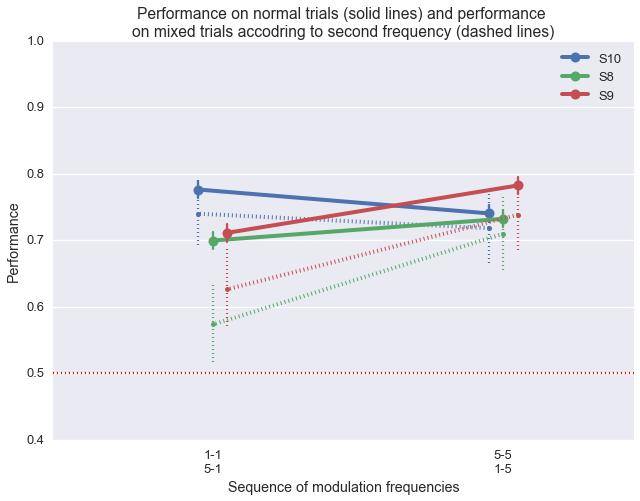

In [232]:
# visualize performance on normal trials + performance on mixed trials 
# (according to second modulation frequency)

for (i,rat) in enumerate(prop_right.index.levels[0]):
    # plot performance on normal trials
    spacing = 0.05
    x_1 = 0+i*spacing
    x_2 = 1+i*spacing
    plt.plot([x_1,x_2],
             nt_perf.loc[(rat,),'perf'].values,
             '-o',c=sns.color_palette(n_colors=3)[i],
             markersize=10,linewidth=4,label=rat)
    
    # plot confidence intervals
    plt.plot([x_1]*2,nt_perf.loc[(rat,'Left'),['ci_0','ci_1']],
            c=sns.color_palette(n_colors=3)[i],label='')
    plt.plot([x_2]*2,nt_perf.loc[(rat,'Right'),['ci_0','ci_1']],
            c=sns.color_palette(n_colors=3)[i],label='')
    
    # plot "performance on second frequency" on mixed trials
    spacing = 0.05
    x_1 = 0+i*spacing
    x_2 = 1+i*spacing
    plt.plot([x_2,x_1],
             prop_right.loc[(rat,),'prop_choices_right'].values,
             ':o',c=sns.color_palette(n_colors=3)[i],
             markersize=5,linewidth=4,label='')
    
    # plot confidence intervals
    plt.plot([x_2]*2,prop_right.loc[(rat,'1-5'),['ci_0','ci_1']],':',
            c=sns.color_palette(n_colors=3)[i],label='')
    plt.plot([x_1]*2,prop_right.loc[(rat,'5-1'),['ci_0','ci_1']],':',
            c=sns.color_palette(n_colors=3)[i],label='')

plt.xlim(-0.5,1.5)
plt.grid('off',axis='x')
plt.xticks([0+spacing*i/2,1+spacing*i/2],['1-1\n5-1','5-5\n1-5'])
plt.xlabel('Sequence of modulation frequencies')

plt.ylim(0.4,1)
plt.ylabel('Performance')

plt.title("""Performance on normal trials (solid lines) and performance 
on mixed trials accodring to second frequency (dashed lines)""")

plt.legend()

# chance level choice
plt.hlines(0.5,*plt.gca().get_xlim(),linestyles=':',colors='r')

plt.show()

The figure above shows that: 
- for all 3 rats normal performance is >=70% for both 5-5 (5 Hz modulation stimuli) and 1-1 (1 Hz modulation stimuli) stimuli
- there is no consistent bias in all rats: while rats S8 and S9 are biased to right, rat S10 is biased to left
- performance (considered as % of choices according to the second modulation frequency in the stimulus) on mixed trials (5-1 and 1-5) is above chance, despite the fact that rats are rewarded on either side
- performance on mixed trials tends to be lower than performance on normal trials, and occasionally it is significantly lower (e.g. performance on 5-1 vs perfrormance on 1-1 for rats S8 and S9); this is consistent with the hypothesis that rats take into account whole 2 sec stimulus on normal trials, albeit putting more weight on the second modulation frequency